<a href="https://colab.research.google.com/github/dianaventura/Defining-Success/blob/main/Keras_CNN_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN for IMDB Dataset

In this notebook, we will demonstrate how to use keras to create, train and evaluate your own CNN algorithm on the imdb movie reviews dataset.


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot

import keras
#Import sequence preprocessing methods
from keras.preprocessing import sequence

#Import the sequential architecture
from keras.models import Sequential

#Import the different layers needed to create a CNN
#First, import your convolutional and max pooling layers
from keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization, Flatten
#Next, we import the dense (fully-connected) and embedding layers
from keras.layers import Dense, Embedding
#Finally, import your layer activations and regulizers - in this case, dropout and activation functions
from keras.layers import Dropout, Activation

from tensorflow.keras.utils import to_categorical

#Keras offers us the ability to import datasets directly into our code using a number of presets.
#We can import all the datasets at once, but it consumes memory, so its better to import only the required one.
from keras.datasets import imdb

In [ ]:
np.random.seed(1) #for reproducibility

# Load the Dataset
Unlike in some of our previous labs, Keras will handle the loading and splitting of the dataset for us in a single function call. This split is static (i.e. it does not change between runs) and is already stratified. If you want to design your own split, or use an evaluation methodology (such as cross-fold-validation or hold out) on your data, then additional work will be required.

In this lab we will use the supplied Keras split, but you should keep the above in mind for your coursework.

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".


That dictionary that is inverted when using load_data assumes the word indices start from 1.

Keras uses index "0" to encode any unknown word; index 1 and 2 to mark the START of a sentence and any out of vocabulary (oov_char ) words such as stop words.
Also oov_char replaces words that were cut out because of the num_words or skip_top limit.
The parameter index_from parameter can be used to miss out these extra indexed word annotates.

See [keras.datasets.imdb.load_data](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification ) method they explain what is being loaded.

So basically the representation has already removed stop words and most of the puntuation and less frequent words are removed from text during preprocessing.

It returns 2 tuples:
- x_train, x_test: list of sequences, which are lists of indexes (integers). If the num_words argument was specified, the maximum possible index value is num_words-1. If the maxlen argument was specified, the largest possible sequence length is maxlen.
- y_train, y_test: list of integer labels (1 or 0).

In [ ]:
MAX_FEATURES=1000 # only use top occuring 1000 words
INDEX_FROM =3   # word index offset

# # modify the default parameters of np.load
# np_load_old = np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
# #Load the dataset, and print the length of the train and test sets.
# print('Loading data...')

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_FEATURES, index_from=INDEX_FROM)
print('An example looks like this:')
print(X_train[0])
print('An example class label vector looks like this:', y_train[0])
print(X_train.shape, 'train sequences')
print(X_test.shape, 'test sequences')

# # restore np.load for future normal usage
# np.load = np_load_old

17464789/17464789 [==============================] - 2s 0us/step
An example looks like this:
[1, 14, 22, 16, 43, 530, 973, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 2, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]
An example class label vector looks 

## How can we view the raw text?
Since the load method provides the already indexed IDs of the word and not the raw words we can use word_to_id method to return the actual word from its index value.

In [ ]:
# A dictionary mapping words to an integer index
word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}

# The first indices are reserved
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<OOV>"] = 2 #out of vocabulary (less frequent)

id_to_word = {value:key for key,value in word_to_id.items()}
print('An example review reconstructed from the index:')
print(' '.join(id_to_word[id] for id in X_train[0] ))

1641221/1641221 [==============================] - 1s 1us/step
An example review reconstructed from the index:
<START> this film was just brilliant casting <OOV> <OOV> story direction <OOV> really <OOV> the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same <OOV> <OOV> as myself so i loved the fact there was a real <OOV> with this film the <OOV> <OOV> throughout the film were great it was just brilliant so much that i <OOV> the film as soon as it was released for <OOV> and would recommend it to everyone to watch and the <OOV> <OOV> was amazing really <OOV> at the end it was so sad and you know what they say if you <OOV> at a film it must have been good and this definitely was also <OOV> to the two little <OOV> that played the <OOV> of <OOV> and paul they were just brilliant children are often left out of the <OOV> <OOV> i think because the stars that play them all <OOV> up are such a b

## Get Vocabulary and max length stats

In [ ]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

Training data: 
(50000,)
(50000,)


In [ ]:
# Summarize number of classes
print("Classes: ")
print(np.unique(y))

Classes: 
[0 1]


In [ ]:
# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(X))))

Number of words: 
998


Finally, we can get an idea of the average review length.

Review length: 
Mean 234.76 words (172.911495) in a review


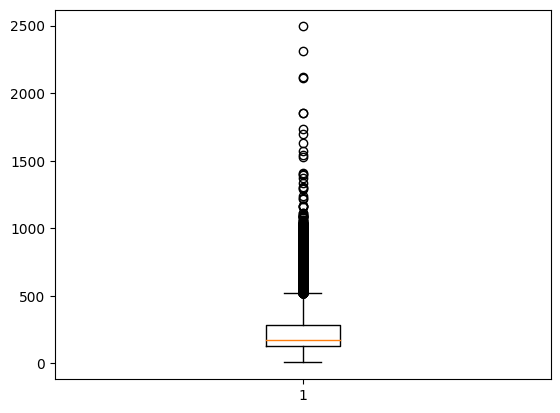

In [ ]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f) in a review" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

Looking at a box and whisker plot for the review lengths in words, we can probably see an exponential distribution that we can probably cover the mass of the distribution with a clipped length of 400 to 500 words.

## Pad the Dataset


After we have loaded the dataset, we need to pad it so that all examples are the same size for submission to the network. We can do that by using a function in Keras.
Here we will bound reviews at maxlen words, truncating longer reviews and zero-padding shorter reviews.

Note that padding will not be needed if you are using sparse representatsions such as from a tfidf vectoriser.


In [ ]:
# set parameters
maxlen = 400

#Find the max example size and ensure that all other examples are padded to this size
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

#Print the data's shape (i.e. the size of each dimension) to check this is done correctly.
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
print('After padding the example looks:')
print(X_train[0])

num_classes = len(np.unique(y))
# convert class labels to binary class one-hot-encoded vectors
y_train_ohe = to_categorical(y_train, num_classes)
y_test_ohe = to_categorical(y_test, num_classes)

Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
After padding the example looks:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173
  36 256   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4
 172 

Recreate the textual content after the padding has been added. You can use the word_to_id method as we did before.

In [ ]:
id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in X_train[0] ))

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

# Creating the CNN Architecture
Now lets create a CNN model. We need to identify several things at this stage:

(1) The parameters of our model (i.e. the hyperparameters of the CNN)

(2) The architecture of our model (i.e. the layers of the CNN)

Firstly lets define the architecture of the model by creating the layers.

In [ ]:
def create_model(max_features = 1000, embedding_dims = 50,  maxlen = 400):
    #Firstly, instantiate a sequential model
    model = Sequential()

    #We can now add layers to this model.
    #Layers are added in the order of Input -> Output (meaning that they are sequential hence the name).
    #Start off with an efficient embedding layer which maps vocab indices into embedding_dims dimensions
    #max_features is the same as vocabulary size defined above
    model.add(Embedding(max_features, embedding_dims, input_length=maxlen))

    #Add a Convolution1D, which will learn filters
    model.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))

    #Add Batch Normalisation to avoid over-fitting
    model.add(BatchNormalization())

    #The use max pooling:
    model.add(GlobalMaxPooling1D())

    #Add a hidden layer:
    model.add(Dense(128, activation='relu'))

    #With batch normalisation
    model.add(BatchNormalization())

    #Project onto a two unit output layer; two for the pos, neg class set
    model.add(Dense(num_classes, activation='softmax'))
    return model

### Create the Model

In [ ]:
#Firstly, lets create our model by calling the function we just made
cnn = create_model()
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 50)           50000     
                                                                 
 conv1d (Conv1D)             (None, 398, 256)          38656     
                                                                 
 batch_normalization (Batch  (None, 398, 256)          1024      
 Normalization)                                                  
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               5

### Training the model
Now that we have a function to create our model, we can apply the training hyperparameters to it.

In [ ]:
#Now lets state the hyperparameters as variables
batch_size = 128
epochs = 10 # try 1 epoch at first

#Loss dictates what function we should use to determine the error
loss = 'binary_crossentropy'

#The optimizer is the function which controls how that error is applied to the network
optimizer = 'adam'

In [ ]:
#Now we can compile and train our model
cnn.compile(loss = loss,  optimizer = optimizer, metrics = ['accuracy'])

In [ ]:
#The 'fit' function will train on your data, and evaluate the accuracy of its performance on the test set at each epoch
#First call the function and specify training data
history = cnn.fit(X_train, y_train_ohe,
        #The identify the batch size
        batch_size = batch_size,
        #Specify your epochs
        epochs = epochs,
        #And identify your evaluation data (remember to put brackets around both x_test and y_test)
        validation_data = (X_test, y_test_ohe))

#note in general evaluation dataset should not be the test set

### Evaluate on test set

In [ ]:
score = cnn.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(score[1]))

Lets create helper function to visualize the loss and accuracy for the training and testing data based on the History callback. This callback, which is automatically applied to each Keras model, records the loss and additional metrics that can be added in the .fit() method. In this case, we are only interested in the accuracy. This helper function employs the matplotlib plotting library:

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)

The above demonstrates clearly that there is over fitting since training accuracy is significantly better than test / validation.
The sweet spot is around 1 or 2 epochs.

# Creating and ANN Architecture

In [ ]:
# max_features = 1000, embedding_dims = 50,  maxlen = 400
model = Sequential()
model.add (Embedding(1000, 50, input_length=400))
model.add (Flatten())
model.add (Dense (units = 1024, activation='relu'))
model.add (Dense ( units = 128, activation='relu'))
model.add (Dense ( units = 2, activation='softmax'))
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
ann_history = model.fit(X_train, y_train_ohe, batch_size=128, epochs=10, validation_data = (X_test, y_test_ohe))
score = model.evaluate(X_test, y_test_ohe)
print('Total loss on the test set', score[0])
print('Total accuracy on the test set', score[1])

In [ ]:
plot_history(ann_history)

# Preparing text from CSV files for a Keras model input

Often we may want to read our data from a CSV and if it is text content them we want to santise that text for instance using regular expressions or stemming etc (as we did last week).
Once that is done we need to convert it into a index vector that can be input.

For this we make use of the keras tokeniser  and texts_to_sequence encoder.
from keras.preprocessing.text import Tokenizer

We look at how to do this next.

In [ ]:
import os
import re

In [ ]:
# remove the non-word chars '[\W]+'
# append the emoticons to end
# convert all to lowercase
# remove nose char for consistency
# remove all html markup
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [ ]:
# Read data from file
data_file = "https://raw.githubusercontent.com/nirmalie/CM4107/main/movie_data_cat.csv"
df = pd.read_csv(data_file,  encoding='utf-8')

#or upload file here and read
# df = pd.read_csv('movie_data_cat.csv', encoding='utf-8')

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['sentiment']))}

#use the mapping dictionary to transform the class labels into integers
df['sentiment'] = df['sentiment'].map(class_mapping)

df['review'] = df['review'].apply(preprocessor)

#make a train test split, we are using a smaller split here, but try the original split as well to compare performance later
X_text_train = df.loc[:2500, 'review'].values
Y_train = df.loc[:2500, 'sentiment'].values
X_text_test = df.loc[2500:5000, 'review'].values
Y_test = df.loc[2500:5000, 'sentiment'].values

# convert class labels to binary class one-hot-encoded vectors
y_train_ohe = to_categorical(Y_train, num_classes)
y_test_ohe = to_categorical(Y_test, num_classes)

In [ ]:
print(X_text_train[0])

### How do we convert the text to a format suited to keras CNN input?

In [ ]:
from keras.preprocessing.text import Tokenizer
# create the tokenizer
tokeniser = Tokenizer(num_words=5000)

# fit the tokenizer on the documents
tokeniser.fit_on_texts(X_text_train)

# summarize what was learned
print(tokeniser.word_counts)
print(tokeniser.word_index)
print(tokeniser.word_docs)
print('Num of training documents', tokeniser.document_count)


# integer encode documents
X_encoded_train = tokeniser.texts_to_sequences(X_text_train)
train_vocab_size = len(tokeniser.word_index) + 1 # Adding 1 because of reserved 0 index

X_encoded_test = tokeniser.texts_to_sequences(X_text_test)
test_vocab_size = len(tokeniser.word_index) + 1 # Adding 1 because of reserved 0 index

print ('train vocabulary size:', train_vocab_size)
print ('test vocabulary size:', test_vocab_size)


In [ ]:
maxlen = 400

In [ ]:
# NOTE: padding is not needed when using tfidf sparce representations
print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_encoded_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_encoded_test, maxlen=maxlen)

#Print the data's shape (i.e. the size of each dimension) to check this is done correctly.
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
print('After padding the example looks:')
print(X_train[0])
print(len(X_train[0]))

Now that the input is in the same format as we had when we loaded it directly from Keras; we can now use this as input into a CNN.
This means that you can now compare the models on text classification with the CNN model using similar text pre-processing steps.

Use the X_train and X_test together with the y_train_ohe and y_test_ohe to create a CNN model.
Once created get a summary, then compile and evaluate.

In [ ]:
def create_model(max_features = 1000, embedding_dims = 50,  maxlen = 400):
    #Firstly, instantiate a sequential model
    model = Sequential()
    model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
    model.add(Conv1D(256, 3, padding='valid', activation='relu', strides=1))
    model.add(BatchNormalization())
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [ ]:
cnn = create_model(maxlen = maxlen)

In [ ]:
cnn.summary()

In [ ]:
cnn.compile(loss = 'binary_crossentropy',  optimizer ='adam', metrics = ['accuracy'])

In [ ]:
history = cnn.fit(X_train, y_train_ohe,
        #The identify the batch size
        batch_size = batch_size,
        #Specify your epochs
        epochs = 10,
        #And identify your test data (remember to put brackets around both x_test and y_test)
        validation_data = (X_test, y_test_ohe))

In [ ]:
score = cnn.evaluate(X_test, y_test_ohe, verbose=False)
print("Testing Accuracy:  {:.4f}".format(score[1]))